<b>Обучить модели</b> <br> 1)random forests,<br> 2) gradient boosted trees. <br>Построить графики зависимости ошибки (на тестовой и обучающейся выборках, а также oob-ошибку) от количества используемых деревьев. Наблюдается ли переобучение/недообучение? Найти значимости признаков. Сделать выводы. Сделать общие выводы по всем лабам. Какой метод оказался лучшим?


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
sns.set(font_scale=1.4)
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')

В этом ноутбуе будем работать с данными, которые обработали в ноутуке income-classification (1).ipynb

In [2]:
df = pd.read_csv('income_preproc.csv')
print(df.shape)
df.head()


(28970, 88)


,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income,x0_Federal-gov,x0_Local-gov,x0_Never-worked,...,x5_Portugal,x5_Puerto-Rico,x5_Scotland,x5_South,x5_Taiwan,x5_Thailand,x5_Trinadad&Tobago,x5_United-States,x5_Vietnam,x5_Yugoslavia
0,0.301370,0.800000,1.0,0.02174,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.800000,1.0,0.00000,0.0,0.122449,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.533333,1.0,0.00000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.400000,1.0,0.00000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.150685,0.800000,0.0,0.00000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


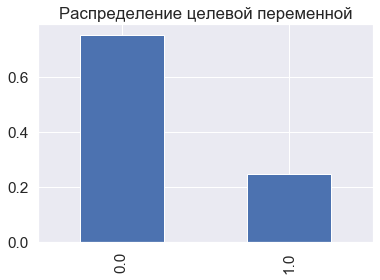

In [3]:
plt.title('Распределение целевой переменной')
df['income'].value_counts(normalize=True).plot(kind='bar')

Разделим выборку на 70% и 30% обучающую и тестовую соответсвенно.

In [5]:
(trainx,
 testx,
 trainy,
 testy) = train_test_split(df.drop('income',axis=1),
                                  df['income'],
                                  test_size = .3,
                                  random_state=18845
                          )
print(f'trainx: {trainx.shape}\ntestx: {testx.shape}')

trainx: (20279, 87)
testx: (8691, 87)


# RandomForestClassifier

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


In [7]:
%%time
from tqdm import tqdm_notebook
from sklearn.metrics import f1_score
result = {'model':[],
          'n_estimator':[],
          'train_f1':[], 
          'test_f1':[], 
          'oob':[], 
          }
for n_estimator in tqdm_notebook(range(10,305,5)):
    model = RandomForestClassifier(n_estimators=n_estimator, 
                                   class_weight='balanced',
                                   oob_score=True,
                                   n_jobs=-1,
                                   random_state = 42,
                                   verbose=0)
    model.fit(trainx,trainy)
    result['model'].append('RandomForest')
    result['n_estimator'].append(n_estimator)
    result['train_f1'].append(round(f1_score(trainy,model.predict(trainx)),3))
    result['test_f1'].append(round(f1_score(testy,model.predict(testx)),3))
    result['oob'].append(model.oob_score_)
r = pd.DataFrame(result)


Wall time: 4min 43s


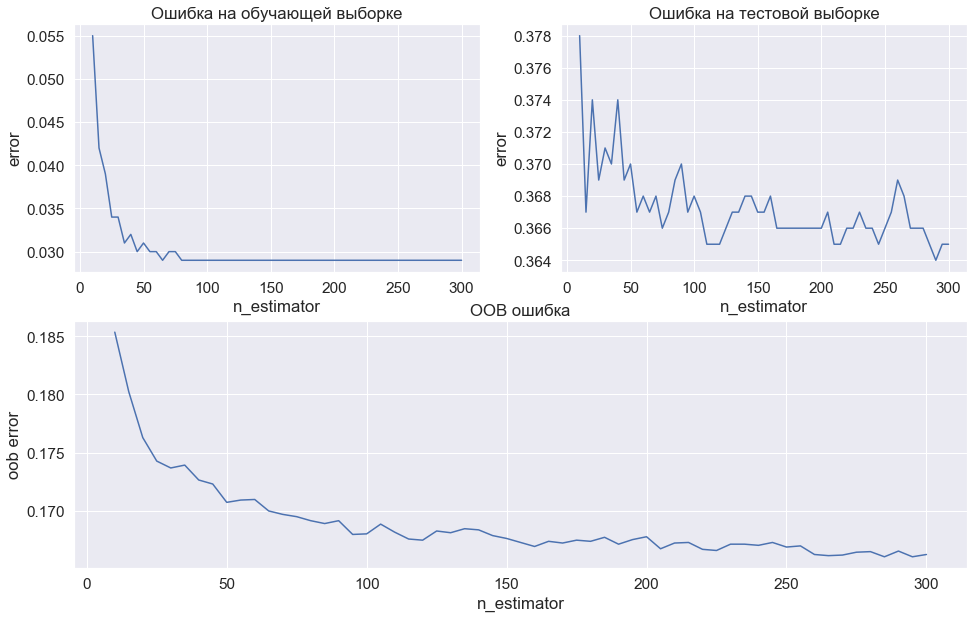

In [9]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.title('Ошибка на обучающей выборке')
sns.lineplot(x = r['n_estimator'], y=1-r['train_f1'])
plt.ylabel('error')

plt.subplot(222)
plt.title('Ошибка на тестовой выборке')
sns.lineplot(x = r['n_estimator'], y=1-r['test_f1'])
plt.ylabel('error')

plt.subplot(212)
plt.title('OOB ошибка')
sns.lineplot(x = r['n_estimator'], y=1 - r['oob'])
plt.ylabel('oob error')

plt.show()

Из верхних двух графикаов видно, что модель сильно переобучается. На обучающей выборке ошибка не перевышает 0.06, а на тестовой выборке ошибка не ниже 0.36.
Переобучение можно обяснить тем, что целевая переменная не сбалансирована и для обучения используется много признаков (после OneHotEncoding, их стало 88). Кроме этого возомжной причиной переобучения может быть глубина дерева, которую не подбирали.

А в целом с ростом количества деревьев в ансамбле, уменьшеается ошибка

Дальше попробуем подбирать гиперпараметры с помощью Байесовской оптимизации

## Bayesian optimization 

In [58]:
#Bayesian optimization
from bayes_opt import BayesianOptimization
def bayesian_optimization(dataset, function, parameters):
    X_train, y_train, X_test, y_test = dataset
    n_iterations = 5
    gp_params = {"alpha": 1e-4}

    BO = BayesianOptimization(function, parameters)
    BO.maximize(n_iter=n_iterations, **gp_params)
    return BO.max
def rfc_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split, max_features):
        return cross_val_score(
               RandomForestClassifier(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   max_features = int(max_features),
                   n_jobs=-1, 
                   random_state=42,   
                   class_weight="balanced"
               ),  
               X=trainx, 
               y=trainy, 
               cv=cv_splits,
               scoring="f1",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (100, 300),
                  "max_depth": (1, 150),
                  "min_samples_split": (2, 20),
                  'max_features':(8,88),
                 }
    
    return function, parameters

def train(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 4
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = RandomForestClassifier(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             max_features = int(params['max_features']),
             n_jobs=-1, 
             random_state=42,   
             class_weight="balanced")

    model.fit(X_train, y_train)
    
    return model

In [12]:
f, p = rfc_optimization(4)
model = train(trainx ,trainy,testx,testy, f,p)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.7135   |  147.7    |  51.72    |  19.7     |  178.4    |
|  2        |  0.7098   |  140.8    |  64.59    |  17.97    |  146.8    |
|  3        |  0.7154   |  55.71    |  11.96    |  16.82    |  236.1    |
|  4        |  0.7161   |  66.08    |  21.62    |  18.17    |  116.9    |
|  5        |  0.6635   |  129.5    |  82.97    |  3.845    |  237.3    |
|  6        |  0.713    |  145.6    |  10.36    |  12.18    |  102.6    |
|  7        |  0.6012   |  1.735    |  31.9     |  15.7     |  103.0    |
|  8        |  0.7147   |  150.0    |  8.0      |  20.0     |  300.0    |
|  9        |  0.7143   |  19.95    |  86.12    |  19.42    |  299.1    |
|  10       |  0.6617   |  8.747    |  10.87    |  19.64    |  294.9    |


In [13]:
from sklearn.metrics import f1_score
round(f1_score(trainy, model.predict(trainx)),3)

0.827

In [14]:
round(f1_score(testy, model.predict(testx)),3)

0.706

Выводим топ 20 признаков, которые имеют наибольшую важность

In [15]:
imp = pd.DataFrame(zip(trainx.columns,
                       model.feature_importances_), 
                   columns=['features', 'importance'])
imp.sort_values(by='importance',ascending=False).head(20)

,features,importance
16,x1_Married-civ-spouse,0.148376
1,education-num,0.127553
0,age,0.114677
3,capital-gain,0.112972
35,x3_Husband,0.104095
5,hours-per-week,0.076734
18,x1_Never-married,0.053144
4,capital-loss,0.033598
40,x3_Wife,0.020527
24,x2_Exec-managerial,0.014591


Несмотря на то, что подбирали наилучшие гиперпараметры, модель сильно переобучается. Стоит рабоать с самими данными. Но на этом мы остановимся

# GradientBoostingClassifier

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
for n_estimator in tqdm_notebook(range(10,305,5)):
    model = GradientBoostingClassifier(n_estimators=n_estimator, 
                                       random_state = 2332
                                      )
    model.fit(trainx,trainy)
    result['model'].append('GradientBoostingClassifier')
    result['n_estimator'].append(n_estimator)
    result['train_f1'].append(round(f1_score(trainy,model.predict(trainx)),3))
    result['test_f1'].append(round(f1_score(testy,model.predict(testx)),3))
    result['oob'].append(None)
r = pd.DataFrame(result)

Text(0, 0.5, 'error')

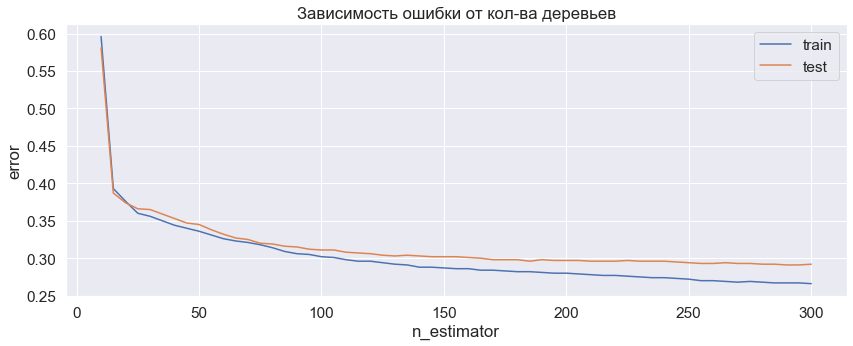

In [49]:
plt.figure(figsize=(14,5))
plt.title('Зависимость ошибки от кол-ва деревьев')
sns.lineplot(x = r_gbc['n_estimator'], y=1-r_gbc['train_f1'],label='train')
sns.lineplot(x = r_gbc['n_estimator'], y=1-r_gbc['test_f1'],label='test',)
plt.ylabel('error')

Переобучение не наблюдается

## GradientBoostingClassifier Bayesian optimization

In [59]:
def gbc_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split, max_features, learning_rate):
        return cross_val_score(
               GradientBoostingClassifier(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   learning_rate=learning_rate,
                   min_samples_split=int(max(min_samples_split,2)), 
                   max_features = int(max_features),
                   max_depth = int(max_depth),
                   random_state=42,   
               ),  
               X=trainx, 
               y=trainy, 
               cv=cv_splits,
               scoring="f1",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (100, 300),
                  'max_depth': (2,30),
                  
                  "min_samples_split": (2, 20),
                  'max_features':(8,88),
                  "learning_rate": (0.05, 0.2),
                 }
    
    return function, parameters
def train(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 4
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]
    

    model = GradientBoostingClassifier(
        
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             max_features = int(params['max_features']),
             learning_rate = params['learning_rate'],
             random_state=42,   
    )

    model.fit(X_train, y_train)
    return model

In [60]:
f, p = gbc_optimization(4)
model = train(trainx ,trainy,testx,testy, f,p)

|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.6534   |  0.05043  |  18.81    |  15.09    |  4.351    |  283.9    |
|  2        |  0.6473   |  0.1661   |  17.47    |  26.42    |  14.79    |  250.8    |
|  3        |  0.6843   |  0.1328   |  9.268    |  31.87    |  16.29    |  271.8    |
|  4        |  0.6592   |  0.1767   |  14.75    |  19.62    |  18.51    |  178.8    |
|  5        |  0.6527   |  0.08388  |  24.72    |  19.55    |  4.27     |  184.2    |
|  6        |  0.7137   |  0.1433   |  8.99     |  86.8     |  15.78    |  101.2    |
|  7        |  0.654    |  0.1448   |  27.08    |  87.58    |  19.02    |  298.1    |
|  8        |  0.675    |  0.14     |  2.847    |  86.87    |  2.031    |  112.9    |
|  9        |  0.6784   |  0.1543   |  2.656    |  87.43    |  18.98    |  108.0    |
|  10       |  0.6676   |  0.1159   |  2.104    |  87.

In [61]:
from sklearn.metrics import f1_score
round(f1_score(trainy, model.predict(trainx)),3)

0.809

In [62]:
round(f1_score(testy, model.predict(testx)),3)

0.705

Выводим топ 20 признаков, которые имеют наибольшую важность

In [74]:
imp = pd.DataFrame(zip(trainx.columns,
                       model.feature_importances_), 
                   columns=['features', 'importance'])
imp.sort_values(by='importance',ascending=False).head(20)

,features,importance
16,x1_Married-civ-spouse,0.323203
3,capital-gain,0.201264
1,education-num,0.146312
4,capital-loss,0.073149
0,age,0.072384
5,hours-per-week,0.053754
24,x2_Exec-managerial,0.012729
11,x0_Self-emp-not-inc,0.007908
28,x2_Other-service,0.007063
40,x3_Wife,0.005696


# Выводы

Модели RandomForest и GradientBoostingClassifier по метрике f1 показали наилучшую точность на обучающей выборке, 0.82 и 0.81 соостветсвенно. Но эти модели переобучались, оценки f1 на тестовой выборке 0.706 и 0.705.

Наилучшей можено считать модель Catboost, f1 на обучающей выборке 0.77, а на тестовой выборке 0.72.
Хотя при обучении catboost-а боролись с несбалансированностью и применили pca